In [1]:
import IO
import numpy as np
import numpy.linalg as linalg
import matplotlib.pyplot as plt
import file_path
%matplotlib inline
DOWN, UP=0,1

2.7.13 |Anaconda custom (64-bit)| (default, Dec 20 2016, 23:09:15) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


In [2]:
def read_data(filename):
    data = IO.LoadBigDict(filename)
    if "GammaG" in data:
        rGammaG = np.array(data["GammaG"]["SmoothT"])
    elif "GGGammaG" in data:
        rGammaG = np.array(data["GGGammaG"]["SmoothT"])
    if "GammaW" in data:
        rGammaW = np.array(data["GammaW"]["SmoothT"])
    elif "WWGammaW" in data:
        rGammaW = np.array(data["WWGammaW"]["SmoothT"])
    Chi = np.array(data["Chi"]["SmoothT"])[0,0,0,0,:,:]
    BKChi = None
    if "BKChi" in data:
        BKChi = np.array(data["BKChi"]["SmoothT"])[0,0,0,0,:,:]
    return (rGammaG, rGammaW, Chi, BKChi)

In [3]:
class SVDBasis:
    def __init__(self, MaxTauBin, beta, bosefermi):
        self.__MaxTauBin=MaxTauBin
        self.__Beta=beta
        self.__Basis={"Beta":beta,"MaxTauBin":MaxTauBin, "BoseFermi":bosefermi}

    def FermiKernel(self, w, t, beta):
        x=beta*w/2
        y=2*t/beta-1
        if x>100:
            return np.exp(-x*(y+1.))
        if x<-100:
            return np.exp(x*(1.0-y))
        return np.exp(-x*y)/(2*np.cosh(x))

    def BoseKernel(self, w, t, beta):
        x=beta*w/2
        y=2*t/beta-1
        if x>200:
            return w*np.exp(-x*(y+1.))
        if x<-200:
            return -w*np.exp(x*(1.0-y))
        return w*np.exp(-x*y)/(2*np.sinh(x))

    def GenerateBasis(self, N):
        Nw=1000
        w=np.linspace(-100,100,Nw)
        Nt=self.__MaxTauBin
        t=np.linspace(0, self.__Beta, Nt+1)
        t=np.array([e+1.0/Nt/2 for e in t[:-1]])
        kMatrix=np.zeros([Nw,Nt])
        if self.__Basis["BoseFermi"] == "Fermi":
            for i in range(len(w)):
                kMatrix[i,:]=self.FermiKernel(w[i],t,self.__Beta)
        elif self.__Basis["BoseFermi"] == "Bose":
            for i in range(len(w)):
                kMatrix[i,:]=self.BoseKernel(w[i],t,self.__Beta)

        u,s,v=linalg.svd(kMatrix)
        v_inv=linalg.inv(v)

        self.__Basis["Number"]=N
        self.__Basis["Basis"]=v_inv[:,:N]
    
    def getBasis(self):
        return self.__Basis

    def Save(self, filename, mode="w"):
        IO.SaveDict(filename, mode, self.__Basis)

In [4]:
def get_fitted_GammaG(coef, basis, nbasis):
    Vol = coef.shape[0]
    maxTauBin = basis.shape[0]
    fitted = np.zeros((Vol,Vol,maxTauBin,maxTauBin), dtype=complex)
    for r1 in range(Vol):
        for r2 in range(Vol):
            for t1 in range(maxTauBin):
                for t2 in range(maxTauBin):
                    fitted[r1,r2,t1,t2] = np.dot(np.dot(basis[t1, :nbasis], coef[r1, r2, :nbasis, :nbasis]),
                                                 basis[t2, :nbasis])
    return fitted

In [5]:
def get_fitted_GammaW(coef, basis, nbasis):
    nspin = coef.shape[0]
    Vol = coef.shape[1]
    maxTauBin = basis.shape[0]
    fitted = np.zeros((nspin,Vol,Vol,maxTauBin,maxTauBin), dtype=complex)
    for s in range(nspin):
        for r1 in range(Vol):
            for r2 in range(Vol):
                for t1 in range(maxTauBin):
                    for t2 in range(maxTauBin):
                        fitted[s,r1,r2,t1,t2] = np.dot(np.dot(basis[t1, :nbasis], coef[s, r1, r2, :nbasis, :nbasis]),
                                                 basis[t2, :nbasis])
    return fitted

In [137]:
def get_fitted_GammaW_specify_s_r(coef, basis, nbasis):
    maxTauBin = basis.shape[0]
    fitted = np.zeros((maxTauBin,maxTauBin), dtype=complex)

    for t1 in range(maxTauBin):
        for t2 in range(maxTauBin):
            fitted[t1,t2] = np.dot(np.dot(basis[t1, :nbasis], coef[:nbasis, :nbasis]),
                                                 basis[t2, :nbasis])
    return fitted

In [185]:
beta = 1.0
order = 4
GammaG, GammaW, Chi, BKChi = read_data("/mnt/data/GammaBK_square/Beta1.0/Beta1.0_Order{}/Weight".format(order))

In [186]:
Vol = GammaG.shape[1]
maxTauBin = GammaG.shape[2]
nspin_G = GammaG.shape[0]
nspin_W = GammaW.shape[0]

In [187]:
n_basis = 30

In [188]:
svd = SVDBasis(maxTauBin, beta, "Fermi")
svd.GenerateBasis(n_basis)
fermi_basis = svd.getBasis()['Basis']

In [189]:
GammaG_coef = np.zeros((nspin_G, Vol, n_basis, n_basis), dtype=complex)

for r1 in range(nspin_G):
    for r2 in range(Vol):
        for i in range(n_basis):
            for j in range(n_basis):
                GammaG_coef[r1, r2, i, j] = np.dot(np.dot(fermi_basis[:, i], GammaG[r1, r2, :,:]), fermi_basis[:, j])

In [190]:
tau = np.array(range(maxTauBin))*beta/maxTauBin
print tau

[ 0.       0.03125  0.0625   0.09375  0.125    0.15625  0.1875   0.21875
  0.25     0.28125  0.3125   0.34375  0.375    0.40625  0.4375   0.46875
  0.5      0.53125  0.5625   0.59375  0.625    0.65625  0.6875   0.71875
  0.75     0.78125  0.8125   0.84375  0.875    0.90625  0.9375   0.96875]


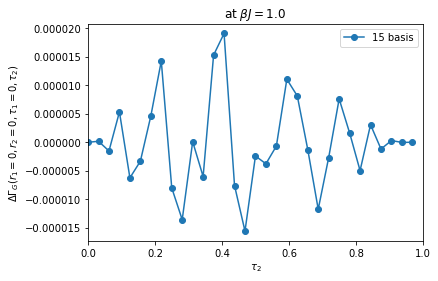

In [191]:
plt.figure()
#plt.plot(tau, GammaG[0,0,0,:],  'o-', c="k", label="Original")
for i in range(15, 16):
    plt.plot(tau, GammaG[0,0,0,:] - get_fitted_GammaG(GammaG_coef, fermi_basis, i)[0,0,0,:],
             'o-', label="{} basis".format(i))
#plt.ylim([0.24, 0.39])
plt.xlim([0,1])
plt.xlabel(r"$\tau_2$")
plt.ylabel(r"$\Delta \Gamma_G(r_1=0,r_2=0,\tau_1=0, \tau_2)$")
plt.title(r"at $\beta J = 1.0$")
plt.legend()

plt.savefig("square_dGammaG_basis_Beta1_Order{}.pdf".format(order))
plt.show()

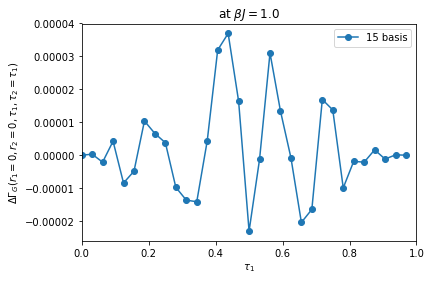

In [192]:
plt.figure()
#plt.plot(tau, GammaG[0,0,:,:].diagonal(),  'o-', c="k", label="Original")
for i in range(15, 16):
    plt.plot(tau, GammaG[0,0,:,:].diagonal()-get_fitted_GammaG(GammaG_coef, fermi_basis, i)[0,0,:,:].diagonal(), 
             'o-', label="{} basis".format(i))
#plt.ylim([0.24, 0.39])
plt.xlim([0,1])
plt.xlabel(r"$\tau_1$")
plt.ylabel(r"$\Delta \Gamma_G(r_1=0,r_2=0,\tau_1, \tau_2=\tau_1)$")
plt.title(r"at $\beta J = 1.0$")
plt.legend()

plt.savefig("square_dGammaG_basis_Beta1_diagonal_Order{}.pdf".format(order))
plt.show()

In [193]:
svd = SVDBasis(maxTauBin, beta, "Bose")
svd.GenerateBasis(n_basis)
bose_basis = svd.getBasis()['Basis']

In [194]:
print GammaW.shape

(6, 64, 64, 32, 32)


In [195]:
GammaW_coef = np.zeros((nspin_W, Vol, Vol, n_basis, n_basis), dtype=complex)
for s in range(nspin_W):
    for r1 in range(Vol):
        for r2 in range(Vol):
            for i in range(n_basis):
                for j in range(n_basis):
                    GammaW_coef[s, r1, r2, i, j] = np.dot(np.dot(bose_basis[:, i], GammaW[s, r1, r2, :, :]), 
                                                       bose_basis[:, j])

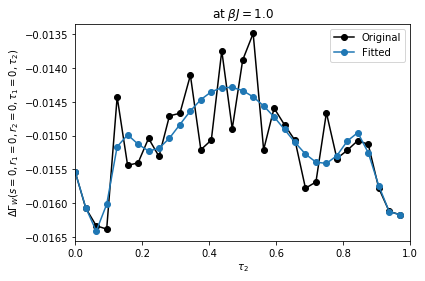

In [196]:
plt.figure()
plt.plot(tau, GammaW[0,0,1,0,:].imag,  'o-', c="k", label="Original")
plt.plot(tau, get_fitted_GammaW_specify_s_r(GammaW_coef[0,0,1], bose_basis, 15)[0,:].imag,  'o-', label="Fitted")
#for i in range(15, 16):
#    plt.plot(tau, GammaW[0,0,1,0,:].imag - get_fitted_GammaW(GammaW_coef, bose_basis, i)[0,0,1,0,:].imag,
#             'o-', label="{} basis".format(i))
#plt.ylim([-0.0150, -0.0148])
plt.xlim([0,1])
plt.xlabel(r"$\tau_2$")
plt.ylabel(r"$\Delta \Gamma_W(s=0, r_1=0,r_2=0,\tau_1=0, \tau_2)$")
plt.title(r"at $\beta J = 1.0$")
plt.legend()

plt.savefig("square_dGammaW_basis_Beta1_Order{}.pdf".format(order))
plt.show()

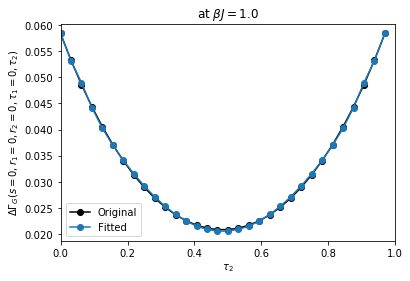

In [171]:
plt.figure()
plt.plot(tau, GammaG[0,0,:,:].diagonal(),  'o-', c="k", label="Original")
plt.plot(tau, get_fitted_GammaG(GammaG_coef, fermi_basis, 10)[0,0,:,:].diagonal(),  'o-', label="Fitted")
#for i in range(15, 16):
#    plt.plot(tau, GammaW[0,0,1,0,:].imag - get_fitted_GammaW(GammaW_coef, bose_basis, i)[0,0,1,0,:].imag,
#             'o-', label="{} basis".format(i))
#plt.ylim([0.24, 0.39])
plt.xlim([0,1])
plt.xlabel(r"$\tau_2$")
plt.ylabel(r"$\Delta \Gamma_G(s=0, r_1=0,r_2=0,\tau_1=0, \tau_2)$")
plt.title(r"at $\beta J = 1.0$")
plt.legend()

plt.savefig("square_dGammaG_basis_Beta1_Order{}.pdf".format(order))
plt.show()

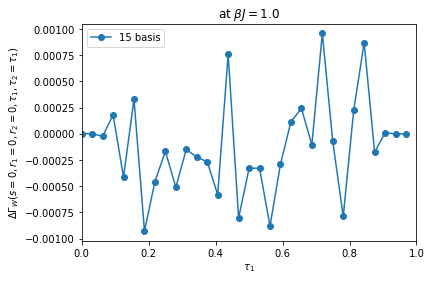

In [106]:
plt.figure()
#plt.plot(tau, GammaG[0,0,0,:],  'o-', c="k", label="Original")
for i in range(15, 16):
    plt.plot(tau, GammaW[0,0,1,:,:].diagonal().imag - get_fitted_GammaW(GammaW_coef, bose_basis, i)[0,0,1,:,:].diagonal().imag,
             'o-', label="{} basis".format(i))
#plt.ylim([0.24, 0.39])
plt.xlim([0,1])
plt.xlabel(r"$\tau_1$")
plt.ylabel(r"$\Delta \Gamma_W(s=0, r_1=0,r_2=0,\tau_1, \tau_2=\tau_1)$")
plt.title(r"at $\beta J = 1.0$")
plt.legend()

plt.savefig("square_dGammaW_basis_Beta1_diagonal_Order{}.pdf".format(order))
plt.show()

In [107]:
print np.max(np.abs(GammaG)), np.max(np.abs(GammaW))

0.377746175371 0.117462800186


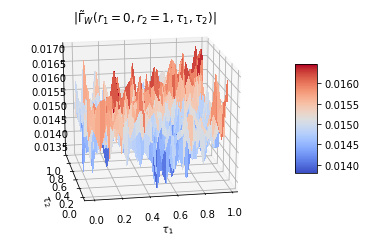

In [108]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

X, Y = np.meshgrid(tau, tau)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot the surface.
surf = ax.plot_surface(X, Y, np.abs(GammaW[0,0,1,:,:]), cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.view_init(20, -100)
ax.set_title(r"$|\tilde{\Gamma}_W(r_1=0, r_2=1, \tau_1, \tau_2)|$")
ax.set_xlabel(r"$\tau_1$")
ax.set_ylabel(r"$\tau_2$")
plt.savefig("square_GammaW_01_Order{}.pdf".format(order))
plt.show()

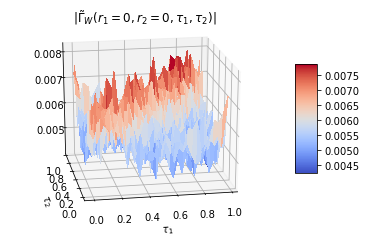

In [109]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

X, Y = np.meshgrid(tau, tau)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot the surface.
surf = ax.plot_surface(X, Y, np.abs(GammaW[0,0,0,:,:]), cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.view_init(20, -100)
ax.set_title(r"$|\tilde{\Gamma}_W(r_1=0, r_2=0, \tau_1, \tau_2)|$")
ax.set_xlabel(r"$\tau_1$")
ax.set_ylabel(r"$\tau_2$")
plt.savefig("square_GammaW_00_Order{}.pdf".format(order))
plt.show()

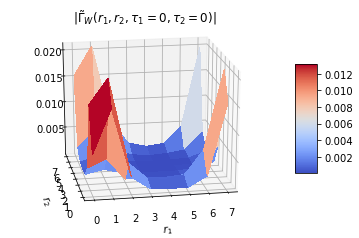

In [110]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
r_list = np.array(range(0,8))
X, Y = np.meshgrid(r_list, r_list)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot the surface.
surf = ax.plot_surface(X, Y, np.abs(GammaW[0,0:8,0:8,0,0]), cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.view_init(20, -100)
ax.set_title(r"$|\tilde{\Gamma}_W(r_1, r_2, \tau_1=0, \tau_2=0)|$")
ax.set_xlabel(r"$r_1$")
ax.set_ylabel(r"$r_2$")
plt.savefig("square_GammaW_r00_Order{}.pdf".format(order))
plt.show()

(6, 64, 64, 32, 32)


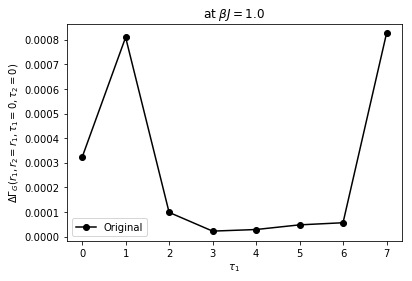

In [128]:
r_list = range(8)
print GammaW.shape
plt.figure()
plt.plot(r_list, np.abs(GammaW[0,4,0:8,0,0]),  'o-', c="k", label="Original")
#plt.ylim([-0.01, 0.01])
#plt.xlim([0,1])
plt.xlabel(r"$\tau_1$")
plt.ylabel(r"$\Delta \Gamma_G(r_1, r_2=r_1, \tau_1=0, \tau_2=0)$")
plt.title(r"at $\beta J = 1.0$")
plt.legend()

plt.savefig("square_GammaG_basis_Beta1_r_Order{}.pdf".format(order))
plt.show()